In [10]:
import sys
sys.path.append("/Users/rq.aita/Códigos/scripts")
sys.path.append("/home/ufpr/Documentos/GitHub/scripts")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import hydrology as hydro
import settings_plot

In [64]:
def coef_determinacao(data, est):
    return 1 - sum((data - est)**2) / sum((data - data.mean())**2)

# Exercício 1

Um teste com um infiltrômetro de 35 cm de diâmetro produziu os seguintes resultados: 

| t (minutos) | Volume total adicionado (cm³) |
|-------------|-------------------------------|
| 0           | 0                             |
| 2           | 278                           |
| 5           | 658                           |
| 10          | 1.173                         |
| 20          | 1.924                         |
| 30          | 2.500                         |
| 60          | 3.345                         |
| 90          | 3.875                         |
| 150         | 4.595                         |

Pede-se traçar o gráfico f x t, onde f é a capacidade de infiltração dada em mm/h.

## Resolução

In [2]:
e_01_dados = {
    "t" : [0, 2, 5, 10, 20, 30, 60, 90, 150],
    "v" : [0, 278, 658, 1173, 1924, 2500, 3345, 3875, 4595],
}
e_01_dados = pd.DataFrame(e_01_dados)#.set_index("t")

### Capacidade de infiltração

$ f = \dfrac{\Delta V / \Delta t}{A} $

Área do infiltrômetro

In [3]:
A = 0.25 * np.pi * 35**2  # cm2

In [9]:
A

962.1127501618741

Diferenças consecutivas

In [4]:
delta = e_01_dados.diff()
delta["f"] = (delta["v"] * 1e+3) / (delta["t"] / 60) / (A * 1e+2)
delta = delta.rename(columns={"t":"dt", "v":"dv"})

In [5]:
e_01_dados = pd.concat([e_01_dados, delta], axis=1)
e_01_dados

,t,v,dt,dv,f
0,0,0,NaN,NaN,NaN
1,2,278,2.0,278.0,86.684227
2,5,658,3.0,380.0,78.992821
3,10,1173,5.0,515.0,64.233636
4,20,1924,10.0,751.0,46.834428
5,30,2500,10.0,576.0,35.920946
6,60,3345,30.0,845.0,17.565509
7,90,3875,30.0,530.0,11.017420
8,150,4595,60.0,720.0,7.483530


### Gráfico

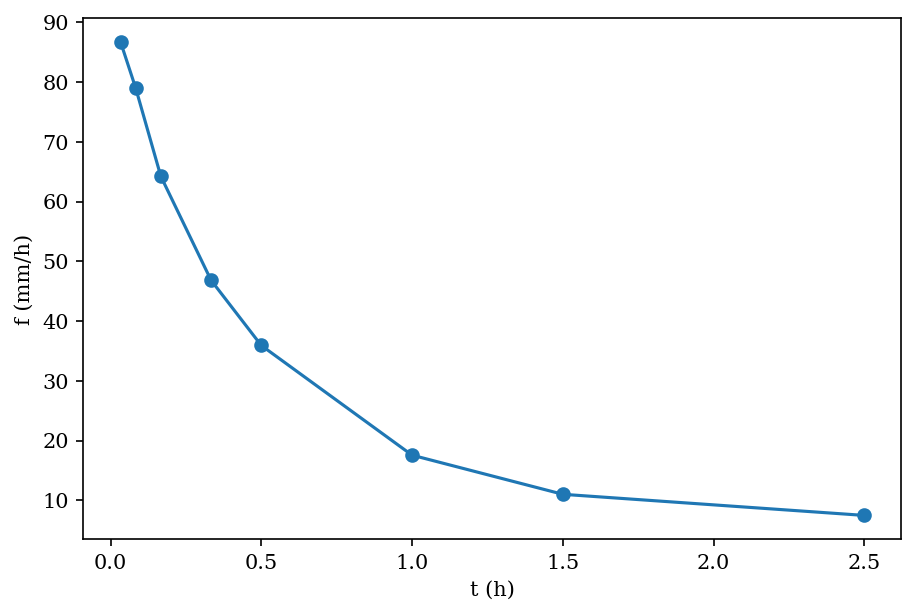

In [8]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(e_01_dados["t"] / 60, delta["f"], marker="o")
ax.set_xlabel("t (h)")
ax.set_ylabel("f (mm/h)")

fig.savefig("figures/l_03_01.png", format="png", dpi=300)
plt.show()

# Exercício 2, 3 e 4

Ajustar a equação de Horton aos dados do **Exercício 1**.

$$
    f_t = f_b + (f_0 - f_b) e^{-kt}
$$
onde $f_t$, $f_0$ e $k$ devem ser obtidos por ajuste.

Ajustar a equação de Philip aos dados do **Exercício 1**.

$$
    V_t = at^{0.5} + bt
$$
onde $a$ e $b$ devem ser obtidos por ajuste.

Transformar a equação de Philip para trabalhar com $f_t$ no lugar de $V_t$ e ajustar novamente a equação de Philip aos dados do **Exercício 1**.

$$
    f_t = 0.5 at^{-0.5} + b
$$
onde $a$ e $b$ devem ser obtidos por ajuste.

## Resolução

In [70]:
fdata = e_01_dados["f"][1:].to_numpy()  # cap. infiltração
tdata = e_01_dados["t"][1:].to_numpy()  # tempo
vdata = e_01_dados["v"][1:].to_numpy()  # vol. infiltrado

### Horton

In [34]:
def horton(t, fb, f0, k):
    return fb + (f0 - fb) * np.exp(-1 * k * t)

In [71]:
popt_horton, pcov_horton = curve_fit(horton, tdata, fdata)
coef_determinacao(fdata, horton(tdata, *popt_horton))

0.9990107625227924

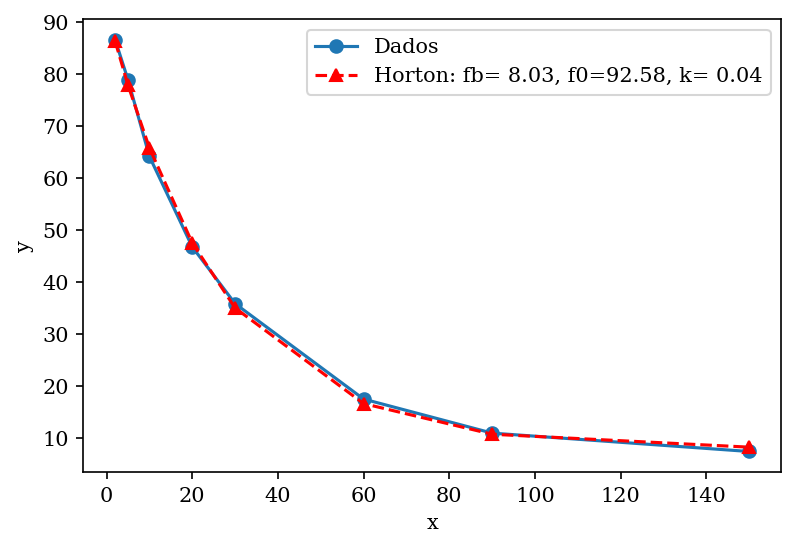

In [87]:
plt.plot(tdata, fdata, 'o-', label="Dados")
plt.plot(tdata, horton(tdata, *popt_horton), 'r^--',
         label='Horton: fb=%5.2f, f0=%5.2f, k=%5.2f' % tuple(popt_horton))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Philip

In [63]:
def philip(t, a, b):
    return a * t**0.5 + b * t

In [73]:
popt_philip, pcov_philip = curve_fit(philip, tdata, vdata)
coef_determinacao(vdata, philip(tdata, *popt_philip))

0.9793200984686475

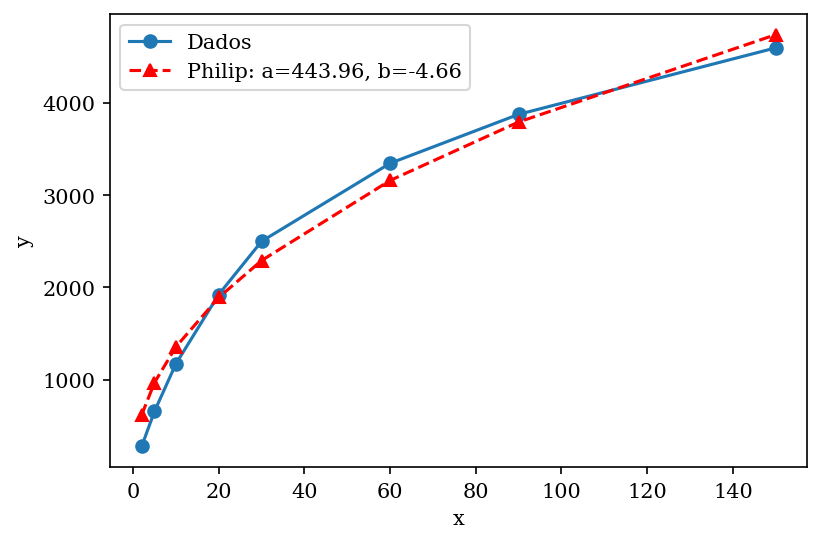

In [90]:
plt.plot(tdata, vdata, 'o-', label="Dados")
plt.plot(tdata, philip(tdata, *popt_philip), 'r^--',
         label='Philip: a=%5.2f, b=%5.2f' % tuple(popt_philip))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Philip com ft

In [114]:
(0.25 * 350**2 * np.pi)

96211.27501618741

In [111]:
def philip_ft(t, a, b):
    return (0.5 * a * t**(-0.5) + b) / (0.25 * 350**2 * np.pi)

In [112]:
popt_philip_ft, pcov_philip_ft = curve_fit(philip_ft, tdata, fdata)
coef_determinacao(fdata, philip_ft(tdata, *popt_philip_ft))

0.8544749149722243

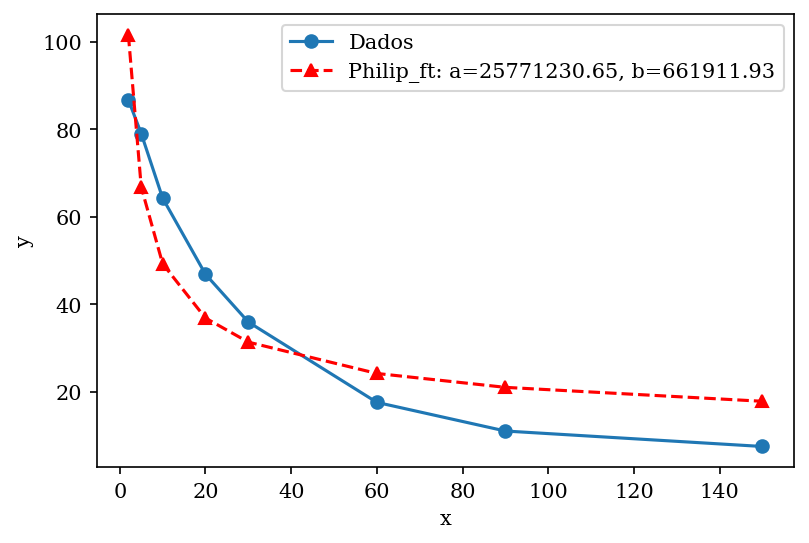

In [113]:
plt.plot(tdata, fdata, 'o-', label="Dados")
plt.plot(tdata, philip_ft(tdata, *popt_philip_ft), 'r^--',
         label='Philip_ft: a=%5.2f, b=%5.2f' % tuple(popt_philip_ft))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()